<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [439]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [440]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow
from skimage.transform import resize

In [442]:
saved_model = load_model('/content/drive/My Drive/xai_model/LG_model.h5')
#texture_model = load_model('/content/drive/My Drive/xai_model/texturenet.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

In [0]:
# from https://github.com/zalkikar/BBOX_GradCAM

class BBoxerwGradCAM():
    
    def __init__(self,learner,heatmap,image_path,resize_scale_list,bbox_scale_list):
        self.learner = learner
        self.heatmap = heatmap
        self.image_path = image_path
        self.resize_list = resize_scale_list
        self.scale_list = bbox_scale_list
        
        self.og_img, self.smooth_heatmap = self.heatmap_smoothing()
        
        self.bbox_coords, self.poly_coords, self.grey_img, self.contours = self.form_bboxes()
        
    def heatmap_smoothing(self):
        og_img = cv2.imread(self.image_path)
        heatmap = cv2.resize(self.heatmap, (self.resize_list[0],self.resize_list[1])) # Resizing
        og_img = cv2.resize(og_img, (self.resize_list[0],self.resize_list[1])) # Resizing
        '''
        The minimum pixel value will be mapped to the minimum output value (alpha - 0)
        The maximum pixel value will be mapped to the maximum output value (beta - 155)
        Linear scaling is applied to everything in between.
        These values were chosen with trial and error using COLORMAP_JET to deliver the best pixel saturation for forming contours.
        '''
        heatmapshow = cv2.normalize(heatmap, None, alpha=0, beta=155, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
        
        return og_img, heatmapshow
    
    def show_smoothheatmap(self):
        cv2_imshow(self.smooth_heatmap)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def show_bboxrectangle(self):
        cv2.rectangle(self.og_img,
                      (self.bbox_coords[0],self.bbox_coords[1]),
                      (self.bbox_coords[0]+self.bbox_coords[2],self.bbox_coords[1]+self.bbox_coords[3]),
                      (0,0,0),3)
        cv2_imshow(self.og_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    def show_contouredheatmap(self):
        img_col = cv2.merge([self.grey_img,self.grey_img,self.grey_img]) # merge channels to create color image (3 channels)
        cv2.fillPoly(img_col, self.contours, [36,255,12]) # fill contours on 3 channel image
        cv2_imshow(img_col)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def show_bboxpolygon(self):
        cv2.polylines(self.og_img,self.poly_coords,True,(0,0,0),2)
        cv2_imshow(self.og_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    def form_bboxes(self):
        grey_img = cv2.cvtColor(self.smooth_heatmap, cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(grey_img,127,255,cv2.THRESH_BINARY)
        im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)

        for item in range(len(contours)):
            cnt = contours[item]
            if len(cnt)>5:
                #print(len(cnt))
                x,y,w,h = cv2.boundingRect(cnt) # x, y is the top left corner, and w, h are the width and height respectively
                poly_coords = [cnt] # polygon coordinates are based on contours
                
                x = int(x*self.scale_list[0]) # rescaling the boundary box based on user input
                y = int(y*self.scale_list[1])
                w = int(w*self.scale_list[2])
                h = int(h*self.scale_list[3])

                return [x,y,w,h], poly_coords, grey_img, contours
            
            else: print("contour error (too small)")
                
    def get_bboxes(self):
        return self.bbox_coords, self.poly_coords

In [0]:
import os
import cv2
import numpy as np
import keras.backend as K
from keras.layers import Conv2D

def read_batch(img_dir, batch_names, batch_sz, sz):
    img_batch = np.empty((batch_sz, sz[0], sz[1], 3), dtype='uint8')
    for i in range(batch_sz):
        tmp = cv2.imread(os.path.join(img_dir, batch_names[i]))
        img_batch[i] = cv2.resize(tmp, (sz[0], sz[1]))
    return img_batch

def get_grad_cam_weights(input_model, dummy_image, should_normalize=True):
    def find_final_layer(model):
        for iter_layer, layer in reversed(list(enumerate(model.layers))):
            if type(layer) == Conv2D:
                return model.layers[iter_layer].name
        raise Exception('Could not find the final layer in provided network')
    final_layer = find_final_layer(input_model)
    conv_output = input_model.get_layer(final_layer).output
    num_classes = input_model.output_shape[1]
    num_feats = int(conv_output.shape[-1])
    weights = np.zeros((num_feats, num_classes))

    def normalize(x):
        # utility function to normalize a tensor by its L2 norm
        return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

    for iter_class in range(input_model.output_shape[1]):
        y_c = input_model.layers[-1].output[0, iter_class]
        if should_normalize:
            grad = normalize(K.gradients(y_c, conv_output)[0])
        else:
            grad = K.gradients(y_c, conv_output)[0]
        grad_func = K.function([input_model.layers[0].input, K.learning_phase()], [conv_output, grad])
        conv_val, grad_val = grad_func([dummy_image, 0])
        conv_val, grad_val = conv_val[0], grad_val[0]
        weights[:, iter_class] = np.mean(grad_val, axis=(0, 1))
    return weights, final_layer

def grad_cam(input_model, weights, images, is_pass_threshold, final_layer, conf_scores, orig_sz=[224, 224],
             should_upsample=False):
    conv_output = input_model.get_layer(final_layer).output  # activation_7
    conv_func = K.function([input_model.layers[0].input], [conv_output])
    conv_val = conv_func([images])
    conv_val = conv_val[0]
    cams = np.einsum('ijkl,lm->ijkm', conv_val, weights)
    if should_upsample:
        old_cams = cams[:]
        cams = np.zeros((old_cams.shape[0], orig_sz[0], orig_sz[1], old_cams.shape[-1]))
        for i in range(cams.shape[0]):
            for j in range(cams.shape[-1]):
                # cams[i, :, :, j] = cv2.resize(old_cams[i, :, :, j], (orig_sz[0], orig_sz[1]))
                cams[i, :, :, j] = np.maximum(cv2.resize(old_cams[i, :, :, j], (orig_sz[0], orig_sz[1])), 0)
    should_normalize = False
    if should_normalize:
        cams = cams / np.maximum(np.max(cams, axis=(1, 2, 3), keepdims=True), 1e-7)
        cams = cams * np.expand_dims(np.expand_dims(conf_scores * is_pass_threshold, axis=1), axis=2)
    else:
        cams = cams * np.expand_dims(np.expand_dims(is_pass_threshold, axis=1), axis=2)
    return cams

[3]
[[6.3732375e-07 1.7406363e-08 1.5399765e-07 9.9999464e-01 2.2388251e-06
  2.4675037e-06]]
Patches


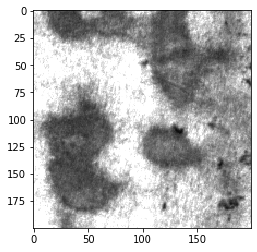

In [446]:
image_path = "/content/drive/My Drive/NEU surface defect database - test split/Test/Pa/Pa_227.bmp"
annotation = '/content/drive/My Drive/NEU surface defect database - test split/ANNOTATIONS/patches_227.xml'

test_input_2 = image.load_img(image_path, target_size=(200,200,3))
b_img = cv2.imread(image_path)
plt.imshow(test_input_2)

test_input2 = image.img_to_array(test_input_2)
test_input2 = np.expand_dims(test_input2, axis=0)
test_input2 /= 255
result = saved_model.predict(test_input2)

prediction = result.argmax(axis=1)
print(prediction)
output = labels[int(prediction)]

print(result)
print(output)

In [447]:
DATASET_ROOT = '/content/drive/My Drive/NEU surface defect database - test split/Test'
CLASSES = ['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc']

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(DATASET_ROOT,
                                                    class_mode='categorical',
                                                    #interpolation='bilinear',
                                                    target_size=(200, 200),
                                                    batch_size=180,
                                                    shuffle=False,
                                                    classes=CLASSES)
unique, counts = np.unique(test_generator.labels, return_counts=True)
print(dict(zip(CLASSES, counts)))

Found 180 images belonging to 6 classes.
{'Cr': 30, 'In': 30, 'PS': 30, 'Pa': 30, 'RS': 30, 'Sc': 30}


In [0]:
# #test_input,y = test_generator.next()
# #print(test_input.shape)

#cur_batch_sz = 180

In [0]:
# #np.save('/content/drive/My Drive/xai_model/grad_test_input',test_input)
test_input = np.load('/content/drive/My Drive/xai_model/grad_test_input.npy')

In [0]:
test_crazing_idx = np.full(len(test_generator.filenames),False)
test_inclusion_idx = np.full(len(test_generator.filenames),False)
test_pitted_surface_idx = np.full(len(test_generator.filenames),False)
test_patches_idx = np.full(len(test_generator.filenames),False)
test_rolledin_scale_idx = np.full(len(test_generator.filenames),False)       
test_scratches_idx = np.full(len(test_generator.filenames),False)  
for i in range(len(test_generator.filenames)):
    for j in range(len(test_generator.filenames[i])):
        if test_generator.filenames[i][j]== "/":
            break
    correct_class = test_generator.filenames[i][0:j]
    if correct_class == "Cr":
        test_crazing_idx[i] = True
    if correct_class == "In":
        test_inclusion_idx[i] = True
    if correct_class == "PS":
        test_pitted_surface_idx[i] = True
    if correct_class == "Pa":
        test_patches_idx[i] = True
    if correct_class == "RS":
        test_rolledin_scale_idx[i] = True
    if correct_class == "Sc":
        test_scratches_idx[i] = True

# print(len(test_input[test_crazing_idx]))
# print(len(test_input[test_inclusion_idx]))
# print(len(test_input[test_pitted_surface_idx]))
# print(len(test_input[test_patches_idx]))
# print(len(test_input[test_rolledin_scale_idx]))
# print(len(test_input[test_scratches_idx]))

In [0]:
alpha, layer = get_grad_cam_weights(saved_model, np.zeros((1, 200, 200, 3)))

In [452]:
print(alpha.shape)
#plt.imshow(alpha)

(1024, 6)


In [453]:
print(layer)

conv_pw_13


In [0]:
Y2 = grad_cam(saved_model, alpha,test_input2, np.ones((len(test_input2), len(CLASSES))), layer, result,
             orig_sz=test_input2.shape[1:3], should_upsample=True)

Text(0.5, 1.0, 'Pa')

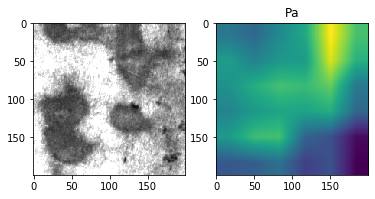

In [455]:
plt.subplot(121)
plt.imshow(test_input_2)
plt.subplot(122)
plt.imshow(Y2[0, :, :, int(prediction)])
plt.title(CLASSES[int(prediction)])

In [0]:
image_resizing_scale = [200,200]
bbox_scaling = [1,1,1,1] 

bbox2 = BBoxerwGradCAM(saved_model,
                      Y2[0, :, :, int(prediction)],
                      image_path,
                      image_resizing_scale,
                      bbox_scaling)

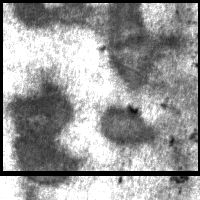

In [457]:
# bbox2.show_smoothheatmap()
# bbox2.show_contouredheatmap()
bbox2.show_bboxrectangle()
# bbox2.show_bboxpolygon()

In [458]:
rect_coords, polygon_coords = bbox2.get_bboxes()
rect_coords

[0, 0, 200, 173]

1


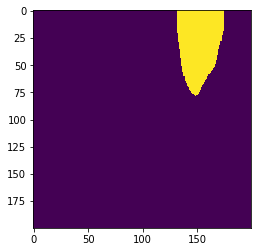

In [459]:
Y2[0,:,:,int(prediction)] = Y2[0,:,:,int(prediction)]/np.amax(Y2[0,:,:,int(prediction)])
for i in range(200):
    for j in range(200):        
        if Y2[0,i,j,int(prediction)] > 0.8: 
            Y2[0,i,j,int(prediction)]=1
        else:
            Y2[0,i,j,int(prediction)]=0
        
print(len(Y2))
plt.imshow(Y2[0, :, :, int(prediction)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


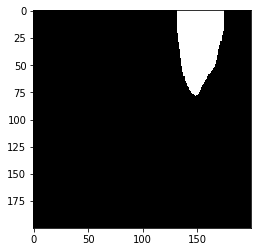

In [460]:
test_mask = np.zeros(b_img.shape)
for i in range(200):
  for j in range(200):
    if Y2[0,i,j,int(prediction)] == 1.0:
      test_mask[i][j] = 255
    else:
      test_mask[i][j] = 0

plt.imshow(test_mask)

In [461]:
from xml.etree import ElementTree
def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes

boxes = extract_boxes(annotation)

print(boxes)

[[1, 66, 84, 193], [93, 101, 160, 149], [98, 1, 163, 94], [7, 1, 101, 29], [166, 164, 194, 188]]


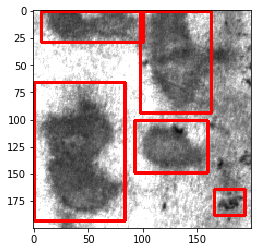

In [462]:
for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  #print(pt1, pt2)
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 2)
  plt.imshow(b_img)

In [0]:
# x_limit = boxes[0][0], boxes[0][2]
# y_limit = boxes[0][1], boxes[0][3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


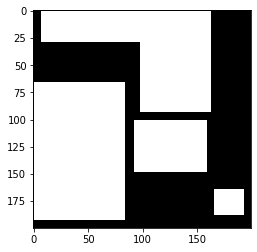

In [464]:
gt_mask = np.zeros(b_img.shape)

for l in range(len(boxes)):
  for i in range(boxes[l][1], boxes[l][3]):
    for j in range(boxes[l][0], boxes[l][2]):
      gt_mask[i][j] = 255 

plt.imshow(gt_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


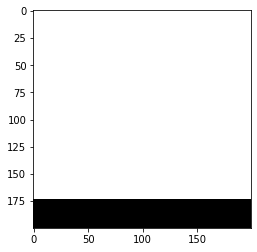

In [465]:
grad_mask = np.zeros(b_img.shape)

for i in range(rect_coords[1], (rect_coords[3]+rect_coords[1])):
  for j in range(rect_coords[0], (rect_coords[2]+rect_coords[0])):
    grad_mask[i][j] = 255 

plt.imshow(grad_mask)

In [466]:
intersection1 = np.logical_and(gt_mask, grad_mask)
union1 = np.logical_or(gt_mask, grad_mask)
iou_score1 = np.sum(intersection1) / np.sum(union1)
print("Box IOU: ",iou_score1)

intersection2 = np.logical_and(gt_mask, test_mask)
union2 = np.logical_or(gt_mask, test_mask)
iou_score2 = np.sum(intersection2) / np.sum(union2)
print("Threshold IOU: ",iou_score2)

Box IOU:  0.5709378407851691
Threshold IOU:  0.08312096500169895


#mIOU calculation:

In [0]:
### NOTE: change input value here:

# labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

input_label = 5

In [0]:
test_idx = [test_crazing_idx, test_inclusion_idx, test_pitted_surface_idx,
            test_patches_idx,test_rolledin_scale_idx, test_scratches_idx]
test_idx = test_idx[input_label]

test_idx_id = input_label

gt_idx = [gt_crazing_idx, gt_inclusion_idx, gt_pitted_surface_idx, 
          gt_patches_idx, gt_rolledin_scale_idx, gt_scratches_idx]
gt_idx = gt_idx[input_label]

In [0]:
true_idx = []
for i, j in enumerate(test_idx):
    if j == True:
        true_idx.append(i)

In [0]:
pred_scores = saved_model.predict(test_input[test_idx])

In [0]:
Y = grad_cam(saved_model, alpha,test_input[test_idx] , np.ones((len(test_input[test_idx]), len(CLASSES))), layer, pred_scores,
             orig_sz=test_input[test_idx].shape[1:3], should_upsample=True)

Text(0.5, 1.0, 'Sc')

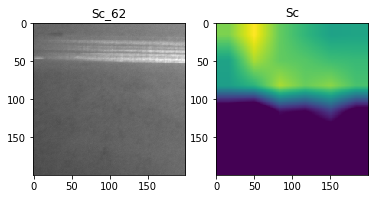

In [472]:
q = 25
score = pred_scores[q].argmax(axis=0)

plt.subplot(121)
plt.imshow(test_input[test_idx][q])
plt.title(os.path.splitext(os.path.basename(test_generator.filenames[true_idx[q]]))[0])
plt.subplot(122)
plt.imshow(Y[q, :, :, score])
plt.title(CLASSES[int(score)])

In [473]:
for k in range(len(Y)):
  Y[k, :, :, test_idx_id] = Y[k, :, :, test_idx_id]/np.amax(Y[k, :, :, test_idx_id])
  for i in range(200):
      for j in range(200):        
          if Y[k, i, j, test_idx_id] > 0.8: 
              Y[k, i, j, test_idx_id] = 1
          else:
              Y[k, i, j, test_idx_id] = 0
        
print(len(Y))
print(CLASSES[test_idx_id])
print(len(test_input[test_idx]))

30
Sc
30


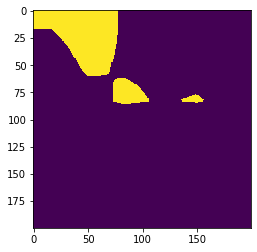

In [474]:
plt.imshow(Y[q, :, :, score])

In [475]:
defect_map = []
for p in range(len(Y)):
  dummy = np.zeros((200, 200, 3))
  for i in range(200):
    for j in range(200):
      if Y[p,i,j,test_idx_id] == 1.0:
        dummy[i][j] = 255
      else:
        dummy[i][j] = 0

  defect_map.append(dummy)

print(len(defect_map))

30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


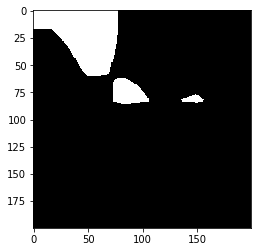

In [476]:
plt.imshow(defect_map[q])

In [477]:
GT_ROOT = '/content/drive/My Drive/NEU surface defect database - test split/GT Test_2'

gt_data_datagen = ImageDataGenerator(rescale=1./255)
gt_generator = gt_data_datagen.flow_from_directory(GT_ROOT,
                                                    class_mode='categorical',
                                                    #interpolation='bilinear',
                                                    target_size=(200, 200),
                                                    batch_size=180,
                                                    shuffle=False,
                                                    classes=CLASSES)
unique, counts = np.unique(gt_generator.labels, return_counts=True)
print(dict(zip(CLASSES, counts)))

Found 180 images belonging to 6 classes.
{'Cr': 30, 'In': 30, 'PS': 30, 'Pa': 30, 'RS': 30, 'Sc': 30}


In [0]:
# grd_truth,y = gt_generator.next()
# print(grd_truth.shape)

In [0]:
#np.save('/content/drive/My Drive/xai_model/grd_truth_next',grd_truth)
grd_truth = np.load('/content/drive/My Drive/xai_model/grd_truth_next.npy')

In [0]:
gt_crazing_idx = np.full(len(gt_generator.filenames),False)
gt_inclusion_idx = np.full(len(gt_generator.filenames),False)
gt_pitted_surface_idx = np.full(len(gt_generator.filenames),False)
gt_patches_idx = np.full(len(gt_generator.filenames),False)
gt_rolledin_scale_idx = np.full(len(gt_generator.filenames),False)       
gt_scratches_idx = np.full(len(gt_generator.filenames),False)  

for i in range(len(gt_generator.filenames)):
    for j in range(len(gt_generator.filenames[i])):
        if gt_generator.filenames[i][j]== "/":
            break
    correct_class = gt_generator.filenames[i][0:j]
    if correct_class == "Cr":
        gt_crazing_idx[i] = True
    if correct_class == "In":
        gt_inclusion_idx[i] = True
    if correct_class == "PS":
        gt_pitted_surface_idx[i] = True
    if correct_class == "Pa":
        gt_patches_idx[i] = True
    if correct_class == "RS":
        gt_rolledin_scale_idx[i] = True
    if correct_class == "Sc":
        gt_scratches_idx[i] = True

# print(len(grd_truth[gt_crazing_idx]))
# print(len(grd_truth[gt_inclusion_idx]))
# print(len(grd_truth[gt_pitted_surface_idx]))
# print(len(grd_truth[gt_patches_idx]))
# print(len(grd_truth[gt_rolledin_scale_idx]))
# print(len(grd_truth[gt_scratches_idx]))

Text(0.5, 1.0, 'GT bounding box')

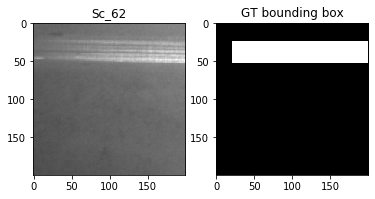

In [481]:
plt.subplot(121)
plt.imshow(test_input[test_idx][q])
plt.title(os.path.splitext(os.path.basename(test_generator.filenames[true_idx[q]]))[0])
plt.subplot(122)
plt.imshow(grd_truth[gt_idx][q])
plt.title('GT bounding box')

In [482]:
intersection = np.logical_and(grd_truth[gt_idx], defect_map)
union = np.logical_or(grd_truth[gt_idx], defect_map)

miou_score = np.sum(intersection) / np.sum(union)
# print(np.sum(intersection))
# print(np.sum(union))

print("mIOU : ",miou_score)

mIOU :  0.23896973659904


In [0]:
# mIOU results:

# Crazing : 0.1665
# Inclusion : 0.1810
# Pitted Surface : 0.2844
# Patches : 0.1986
# Rolled-in Scale : 0.2468
# Scratches : 0.2389

mIOU results:

Crazing : 0.1665
Inclusion : 0.1810
Pitted Surface : 0.2844
Patches : 0.1986
Rolled-in Scale : 0.2468
Scratches : 0.2389